# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

1.1

I began by importing necessary packages. Then I look at each of the tables to see what information is within each table. I determine that mobile_food_schedule table is most useful, therefore I select distinct pairs of locationid and permit using sql, then I look up the permitid on mobile_food_permits to determine the vendor. It is important to note that permits can either be Approved, Requested, or Expired. However I have decided to ignore status as the vendors are still selling regardless of these permits and the consumer does not care on the status of the vendor, only if they are selling or not. 


In [43]:
## Import all necessary packages at the beginning

import sqlite3 as sql
import pandas as pd
import statsmodels.formula.api as sm

# Make Jupyter to automatically display matplotlib plots.
%matplotlib inline
# Make plots larger.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
from mpl_toolkits.basemap import Basemap


import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import numpy as np
import shapely.geometry as geom

import os
os.chdir("C:\Users\Moxigeren\Desktop\STA141B")


In [2]:
db = sql.connect("sf_data.sqlite")

In [3]:
cursor = db.execute("SELECT * FROM sqlite_master")
cursor.fetchall()

[(u'table',
  u'crime',
  u'crime',
  2,
  u'CREATE TABLE "crime" (\n"IncidntNum" INTEGER,\n  "Category" TEXT,\n  "Descript" TEXT,\n  "DayOfWeek" TEXT,\n  "Datetime" TIMESTAMP,\n  "PdDistrict" TEXT,\n  "Resolution" TEXT,\n  "Address" TEXT,\n  "Lon" REAL,\n  "Lat" REAL\n)'),
 (u'table',
  u'noise',
  u'noise',
  35775,
  u'CREATE TABLE "noise" (\n"CaseID" INTEGER,\n  "Type" TEXT,\n  "Address" TEXT,\n  "Neighborhood" TEXT,\n  "Datetime" TIMESTAMP,\n  "Lat" REAL,\n  "Lon" REAL\n)'),
 (u'table',
  u'parking',
  u'parking',
  35921,
  u'CREATE TABLE "parking" (\n"Owner" TEXT,\n  "Address" TEXT,\n  "PrimeType" TEXT,\n  "SecondType" TEXT,\n  "GarOrLot" TEXT,\n  "RegCap" INTEGER,\n  "ValetCap" INTEGER,\n  "MCCap" INTEGER,\n  "LandType" TEXT,\n  "Lat" REAL,\n  "Lon" REAL\n)'),
 (u'table',
  u'schools',
  u'schools',
  35944,
  u'CREATE TABLE "schools" (\n"Name" TEXT,\n  "Entity" TEXT,\n  "LowerGrade" INTEGER,\n  "UpperGrade" INTEGER,\n  "GradeRange" TEXT,\n  "Category" TEXT,\n  "LowerAge" INTEG

In [4]:
db.row_factory = sql.Row

In [5]:
cursor = db.execute("SELECT * FROM sqlite_master")
rows = cursor.fetchall()

In [6]:
rows

In [7]:
rows[0].keys()

['type', 'name', 'tbl_name', 'rootpage', 'sql']

In [8]:
rows[0]['name']

u'crime'

In [9]:
rows[1]['name']

u'noise'

In [10]:
rows[2]['name']

u'parking'

In [11]:
data = db.execute("SELECT * FROM mobile_food_schedule")


In [12]:
from sqlalchemy import update
import sqlalchemy
sqlalchemy.__version__

'1.0.13'

In [13]:
import pandas as pd

pd.read_sql("SELECT * FROM sqlite_master", db)

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."


In [14]:
pd.read_sql("SELECT * FROM mobile_food_permits", db)

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,16MFF-0027,APPROVED,F & C Catering,Truck,Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...,1,2016-03-09 12:00:00,2017-03-15 12:00:00
1,13MFF-0102,EXPIRED,Natan's Catering,Truck,Burgers: melts: hot dogs: burritos:sandwiches:...,1,2013-04-12 12:00:00,2014-03-15 12:00:00
2,16MFF-0069,APPROVED,Munch A Bunch,Truck,Cold Truck: packaged sandwiches: pitas: breakf...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
3,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
4,16MFF-0010,REQUESTED,Pipo's Grill,Truck,Tacos: Burritos: Hot Dogs: and Hamburgers,0,None,None
5,16MFF-0024,APPROVED,"Off the Grid Services, LLC",Truck,Everything,0,2016-03-17 12:00:00,2017-03-15 12:00:00
6,14MFF-0034,EXPIRED,Bach Catering,Truck,Cold Truck: Cheeseburgers: Burgers: Chicken Ba...,1,2014-03-13 12:00:00,2015-03-15 12:00:00
7,16MFF-0048,REQUESTED,Singh Brothers Ice Cream,Truck,Ice Cream: Pre-Packaged Chips: Candies: Bottle...,1,None,2017-03-15 12:00:00
8,16MFF-0036,APPROVED,Roadside Rotisserie Corporation / Country Grill,Truck,Rotisserie Chicken: Ribs: Kickass Salad: Potat...,0,2016-03-10 12:00:00,2017-03-15 12:00:00
9,14MFF-0001,EXPIRED,Sun Rise Catering,Truck,Cold Truck: sandwiches: drinks: snacks: candy:...,1,2014-09-10 12:00:00,2015-03-15 12:00:00


In [15]:
pd.read_sql("SELECT * FROM mobile_food_locations", db)

,locationid,LocationDescription,Address,Latitude,Longitude
0,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532
1,437211,MISSOURI ST: 20TH ST to SIERRA ST (500 - 630),555 MISSOURI ST,37.759304,-122.395902
2,765880,17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299),2222 17TH ST,37.765216,-122.406007
3,765690,CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...,2323 CESAR CHAVEZ ST,37.748801,-122.400552
4,751253,FOLSOM ST: 14TH ST to 15TH ST (1800 - 1899),1800 FOLSOM ST,37.767852,-122.416105
5,761933,05TH ST: BLUXOME ST to TOWNSEND ST (650 - 699),670 05TH ST,37.775589,-122.397977
6,526124,INDUSTRIAL ST: PALOU AVE to QUESADA AVE (51 - ...,75 INDUSTRIAL ST,37.739217,-122.400864
7,765527,FITZGERALD AVE: HAWES ST to INGALLS ST (1100 -...,1104 FITZGERALD AVE,37.720175,-122.389407
8,761934,BRANNAN ST: STANFORD ST to JACK LONDON ALY (32...,340 BRANNAN ST,37.781265,-122.393229
9,763522,BUSH ST: 01ST ST \ MARKET ST to BATTERY ST (1 ...,1 BUSH ST,37.790922,-122.400100


In [103]:
pd.read_sql("SELECT * FROM noise", db)


,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon
0,5130305,other_excessive_noise,Not associated with a specific address,None,2015-09-25 00:29:33,NaN,NaN
1,6446138,amplified_sound_electronics,Intersection of CLINTON PARK and GUERRERO ST,Mission Dolores,2016-10-21 13:20:18,37.769148,-122.424475
2,5929789,other_excessive_noise,"1301 48TH AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 11:38:59,37.762047,-122.508365
3,5659943,other_excessive_noise,"736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",Lower Nob Hill,2016-03-13 01:18:27,37.787983,-122.414943
4,5930704,other_excessive_noise,"1360 43RD AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 13:58:43,37.761385,-122.502232
5,6427526,construction_private_property,"108 VIRGINIA AVE, SAN FRANCISCO, CA, 94110",Bernal Heights,2016-10-17 07:28:37,37.742435,-122.420087
6,5661647,amplified_sound_electronics,"801 25TH AVE, SAN FRANCISCO, CA, 94121",Outer Richmond,2016-03-13 23:27:11,37.774201,-122.484448
7,5661981,construction_public,"1275 COLUMBUS AVE, SAN FRANCISCO, CA, 94133",Fisherman's Wharf,2016-03-14 08:09:25,37.805616,-122.418177
8,6423810,other_excessive_noise,"779 LA PLAYA, SAN FRANCISCO, CA, 94121",Outer Richmond,2016-10-15 12:36:45,37.773767,-122.510212
9,5932159,amplified_sound_electronics,"1331 FOLSOM ST, SAN FRANCISCO, CA, 94103",South of Market,2016-06-01 17:48:41,37.773292,-122.411780


In [16]:
pd.read_sql("SELECT * FROM crime", db)

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469
5,150098232,NON-CRIMINAL,AIDED CASE -PROPERTY FOR DESTRUCTION,Sunday,2015-02-01 16:21:00,RICHMOND,NONE,400 Block of LOCUST ST,-122.451782,37.787085
6,150098248,SECONDARY CODES,DOMESTIC VIOLENCE,Saturday,2015-01-31 21:00:00,BAYVIEW,NONE,700 Block of KIRKWOOD AV,-122.374019,37.729203
7,150098248,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Saturday,2015-01-31 21:00:00,BAYVIEW,NONE,700 Block of KIRKWOOD AV,-122.374019,37.729203
8,150098254,BURGLARY,"BURGLARY OF STORE, UNLAWFUL ENTRY",Saturday,2015-01-31 16:09:00,CENTRAL,NONE,200 Block of STOCKTON ST,-122.406568,37.787809
9,150098260,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Saturday,2015-01-31 17:00:00,CENTRAL,NONE,800 Block of GEARY ST,-122.417295,37.786258


In [17]:
pd.read_sql("SELECT * FROM parking", db)


,Owner,Address,PrimeType,SecondType,GarOrLot,RegCap,ValetCap,MCCap,LandType,Lat,Lon
0,Private,2110 Market St,PPA,,L,13,0,0,restaurant,37.767378,-122.429344
1,SFMTA,993 Potrero,PPA,,L,34,0,0,,37.757272,-122.406320
2,Port of SF,601 Terry A Francois Blvd,PPA,,L,72,0,0,,37.770135,-122.385801
3,Private,11 SOUTH VAN NESS,PHO,CPO,G,130,0,0,,37.774150,-122.418402
4,Private,101 CALIFORNIA ST,PPA,,G,250,0,0,,37.793243,-122.397495
5,Private,2000 POST ST,PPA,,G,304,0,0,,37.785078,-122.434745
6,Private,600 CALIFORNIA ST,PPA,,G,197,0,0,,37.792779,-122.404392
7,Private,35 GILBERT ST,PPA,,,80,0,0,,37.774337,-122.403257
8,Private,2355 POST ST,PPA,,L,50,0,0,,37.783970,-122.440218
9,RPD,801 STANYAN ST,PPA,,L,324,0,0,,37.767202,-122.453432


In [18]:
pd.read_sql("SELECT * FROM schools", db)

,Name,Entity,LowerGrade,UpperGrade,GradeRange,Category,LowerAge,UpperAge,GeneralType,Address,Lat,Lon
0,Alamo Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"250 23RD AVE, San Francisco, CA 94121",37.783005,-122.482300
1,Alvarado Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"625 DOUGLASS ST, San Francisco, CA 94114",37.753681,-122.438194
2,Aptos Middle School,SFUSD,6,8,6-8,USD Grades 6-8,11,13,PS,"105 APTOS AVE, San Francisco, CA 94127",37.729672,-122.465782
3,Argonne Early Education School,SFUSD,-2,0,PK-TK,USD PreK/TK,3,5,PS,"750 16TH AVE, San Francisco, CA 94118",37.773968,-122.474060
4,Argonne Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"680 18TH AVE, San Francisco, CA 94121",37.775307,-122.476311
5,"Asawa, Ruth Asawa San Francisco School Of The ...",SFUSD,9,12,9-12,USD Grades 9-12,14,17,PS,"555 PORTOLA DR, SAN FRANCISCO CA, 94131",37.745316,-122.448830
6,Balboa High School,SFUSD,9,12,9-12,USD Grades 9-12,14,17,PS,"1000 CAYUGA AVE, San Francisco, CA 94112",37.721142,-122.441399
7,"Brown, Willie Brown Jr Middle School",SFUSD,6,8,6-8,USD Grades 6-8,11,13,PS,"2055 SILVER AVE, San Francisco, CA 94124",37.736477,-122.399574
8,Bryant Early Education / Bryant Elementary,SFUSD,-2,5,PK-5,"USD PreK-5, Grades K-5",3,10,PS,"2641 25TH ST, San Francisco, CA 94110",37.751453,-122.404694
9,Buena Vista / Horace Mann,SFUSD,0,8,K-8,USD Grades K-8,5,13,PS,"3351 23RD ST, San Francisco, CA 94110",37.753033,-122.420181


In [19]:
pd.read_sql("SELECT *, COUNT(*) FROM noise GROUP BY Neighborhood", db)

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon,COUNT(*)
0,6677375,delivery_service_business,"1268 8TH AVE, SAN FRANCISCO, CA, 94122",None,2016-12-30 20:38:24,37.764678,-122.465148,545
1,6550773,garbage_recycling_collection,"942 HAYES ST, SAN FRANCISCO, CA, 94117",Alamo Square,2016-11-21 06:38:37,37.775853,-122.431924,22
2,6481907,mechanical_equipment,"2425 GEARY BLVD, SAN FRANCISCO, CA, 94115",Anza Vista,2016-10-31 19:21:03,37.782569,-122.443689,8
3,5217968,other_excessive_noise,"869 NORTH POINT ST, SAN FRANCISCO, CA, 94109",Aquatic Park / Ft. Mason,2015-10-23 12:07:15,37.805457,-122.421439,9
4,6678357,amplified_sound_electronics,"157 PARNASSUS AVE, SAN FRANCISCO, CA, 94117",Ashbury Heights,2016-12-31 12:44:14,37.764500,-122.451412,11
5,6345653,construction_private_property,"1401 MONTEREY BLVD, SAN FRANCISCO, CA, 94127",Balboa Terrace,2016-09-24 08:12:28,37.731599,-122.463938,1
6,6659935,other_excessive_noise,Intersection of NEWHALL ST and MCKINNON AVE,Bayview,2016-12-24 23:30:02,37.736907,-122.391088,48
7,6701211,garbage_recycling_collection,"199 TIFFANY AVE, SAN FRANCISCO, CA, 94110",Bernal Heights,2017-01-07 01:20:17,37.744336,-122.421587,76
8,6651670,other_excessive_noise,"1885 BAY SHORE BLVD, SAN FRANCISCO, CA, 94124",Bret Harte,2016-12-21 20:41:46,37.718457,-122.398449,22
9,6447014,construction_public,"1036 14TH ST, SAN FRANCISCO, CA, 94114",Buena Vista,2016-10-21 16:33:34,37.767368,-122.436646,24


In [20]:
test = db.execute("SELECT locationid, permit, COUNT(*) FROM (SELECT DISTINCT locationid, permit FROM mobile_food_schedule) T GROUP BY locationid, permit")

In [21]:
test.fetchall()

In [22]:
unique = pd.read_sql("SELECT locationid, permit, COUNT(*) FROM (SELECT DISTINCT locationid, permit FROM mobile_food_schedule) T GROUP BY locationid, permit", db)

In [23]:
unique.permit.value_counts()

17MFF-0110    58
13MFF-0102    37
17MFF-0111    37
17MFF-0090    33
16MFF-0051    23
16MFF-0048    21
17MFF-0084    19
14MFF-0001    19
14MFF-0109    19
16MFF-0037    17
17MFF-0073    17
17MFF-0091    16
17MFF-0089    15
17MFF-0095    15
16MFF-0027    13
17MFF-0092    13
17MFF-0109    13
14MFF-0034    11
16MFF-0069    10
16MFF-0053     7
17MFF-0125     7
16MFF-0019     7
17MFF-0079     5
17MFF-0078     5
16MFF-0047     5
14MFF-0035     5
17MFF-0104     5
17MFF-0094     4
16MFF-0096     4
16MFF-0046     4
              ..
16MFF-0122     1
16MFF-0087     1
17MFF-0122     1
16MFF-0118     1
16MFF-0080     1
17MFF-0107     1
15MFF-0024     1
17MFF-0101     1
16MFF-0117     1
17MFF-0102     1
17MFF-0108     1
16MFF-0066     1
16MFF-0062     1
16MFF-0121     1
16MFF-0109     1
16MFF-0065     1
15MFF-0023     1
16MFF-0114     1
14MFF-0052     1
16MFF-0068     1
14MFF-0056     1
17MFF-0124     1
17MFF-0100     1
16MFF-0116     1
13MFF-0124     1
17MFF-0126     1
17MFF-0105     1
13MFF-0127    

In [25]:
pd.read_sql("SELECT * FROM mobile_food_permits WHERE permit = '17MFF-0110' ", db)


,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,17MFF-0110,REQUESTED,May Catering,Truck,Cold Truck: Sandwiches: fruit: snacks: candy: ...,1,None,2018-05-06 12:00:00


1.2.1

My first question is asking what the the most popular day of the week is for serving. I was curious into this as when I worked for a company the most popular day for us was Fridays as that was the day we had the most free time due to finishing most of our work the beginning of the week. I began by reading sql table mobile_food_schedule as it contains locationid, permit, DayOfWeek, End Hour, and Start hour. While I was considering looking into a combination of days and hours, I decided just to look at Days because for many people a popular food truck showing up for one hour on one day is more important than being open for several hours on another day where they can not attend. I found count of permit id and day and found the most popular to be 17MFF-0110 appearing on Mondays 86 times. Looking up 17MFF-0110 using mobile_food_permits find the truck to be May Catering. The next truck with most instances is Nathans Catering.

In [26]:
pd.read_sql("SELECT * FROM mobile_food_schedule", db)

,locationid,permit,DayOfWeek,EndHour,StartHour
0,305727,11MFF-0040,Mo,15,10
1,305727,11MFF-0040,Tu,15,10
2,305727,11MFF-0040,We,15,10
3,305727,11MFF-0040,Th,15,10
4,305727,11MFF-0040,Fr,15,10
5,305727,11MFF-0040,Sa,15,10
6,305727,11MFF-0040,Su,15,10
7,305727,11MFF-0040,Mo,20,17
8,305727,11MFF-0040,Tu,20,17
9,305727,11MFF-0040,We,20,17


In [27]:
schedule = pd.read_sql("SELECT * FROM mobile_food_schedule", db)
schedule['hours'] = (schedule['EndHour']-schedule['StartHour'])
schedule

,locationid,permit,DayOfWeek,EndHour,StartHour,hours
0,305727,11MFF-0040,Mo,15,10,5
1,305727,11MFF-0040,Tu,15,10,5
2,305727,11MFF-0040,We,15,10,5
3,305727,11MFF-0040,Th,15,10,5
4,305727,11MFF-0040,Fr,15,10,5
5,305727,11MFF-0040,Sa,15,10,5
6,305727,11MFF-0040,Su,15,10,5
7,305727,11MFF-0040,Mo,20,17,3
8,305727,11MFF-0040,Tu,20,17,3
9,305727,11MFF-0040,We,20,17,3


In [28]:
day = pd.read_sql("SELECT [permit], [DayOfWeek], COUNT(*) AS [COUNT] FROM mobile_food_schedule GROUP BY [permit], [DayOfWeek] ORDER BY [Count] DESC", db)
day

,permit,DayOfWeek,COUNT
0,17MFF-0110,Mo,86
1,13MFF-0102,Mo,73
2,17MFF-0110,Fr,62
3,17MFF-0110,Th,62
4,17MFF-0110,Tu,62
5,17MFF-0110,We,62
6,17MFF-0111,Fr,42
7,17MFF-0111,Mo,42
8,17MFF-0111,Th,42
9,17MFF-0111,Tu,42


In [29]:
pd.read_sql("SELECT * FROM mobile_food_permits WHERE permit = '17MFF-0110' ", db)

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,17MFF-0110,REQUESTED,May Catering,Truck,Cold Truck: Sandwiches: fruit: snacks: candy: ...,1,None,2018-05-06 12:00:00


In [30]:
pd.read_sql("SELECT * FROM mobile_food_permits WHERE permit = '13MFF-0102' ", db)


,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,13MFF-0102,EXPIRED,Natan's Catering,Truck,Burgers: melts: hot dogs: burritos:sandwiches:...,1,2013-04-12 12:00:00,2014-03-15 12:00:00


1.2.2
My next question was regarding noise complaints. This is important for people who may be looking to purchase housing as many people cite noise issues as a top concern for buying. I used the noise table using sql, when I first plotted the points I noticed there was a point to the very far right, it was evident this point was not in the SF area so I subset the data to exclude this point. However I did not delete it incase I wanted to interact with the point later. I first plotted the locations of the noise complaints using long/lat and then plotted this over the SF area map from cb_2015_us_zcta510_500k using gpd_readfile. I also subset the data by looking at only points in the SF area by finding the max and min zip codes in the SF area. Noise complaints appear to be clustered around the northeast part, this makes sense as this is where the area is heavily concentrated due to the financial district. The areas with the least noise complaints are Presidio, a national park, and 94132 which is also an area heavily filled with parks. Another area with minimal noise complains is treasue island. 

In [31]:
noise = pd.read_sql("SELECT * FROM noise", db)
noise = noise[pd.notnull(noise['Lon'])]
noise = noise[pd.notnull(noise['Lat'])]

In [32]:
noise = noise.loc[noise['Lon'] < -122.0]

In [33]:
noise

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon
1,6446138,amplified_sound_electronics,Intersection of CLINTON PARK and GUERRERO ST,Mission Dolores,2016-10-21 13:20:18,37.769148,-122.424475
2,5929789,other_excessive_noise,"1301 48TH AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 11:38:59,37.762047,-122.508365
3,5659943,other_excessive_noise,"736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",Lower Nob Hill,2016-03-13 01:18:27,37.787983,-122.414943
4,5930704,other_excessive_noise,"1360 43RD AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 13:58:43,37.761385,-122.502232
5,6427526,construction_private_property,"108 VIRGINIA AVE, SAN FRANCISCO, CA, 94110",Bernal Heights,2016-10-17 07:28:37,37.742435,-122.420087
6,5661647,amplified_sound_electronics,"801 25TH AVE, SAN FRANCISCO, CA, 94121",Outer Richmond,2016-03-13 23:27:11,37.774201,-122.484448
7,5661981,construction_public,"1275 COLUMBUS AVE, SAN FRANCISCO, CA, 94133",Fisherman's Wharf,2016-03-14 08:09:25,37.805616,-122.418177
8,6423810,other_excessive_noise,"779 LA PLAYA, SAN FRANCISCO, CA, 94121",Outer Richmond,2016-10-15 12:36:45,37.773767,-122.510212
9,5932159,amplified_sound_electronics,"1331 FOLSOM ST, SAN FRANCISCO, CA, 94103",South of Market,2016-06-01 17:48:41,37.773292,-122.411780
10,5932303,amplified_sound_electronics,Intersection of SUTTER ST and BRODERICK ST,Lower Pacific Heights,2016-06-01 18:22:47,37.785036,-122.441537


In [34]:
lonlatnoise = [geom.Point(Lon, Lat) for Lon, Lat in zip(noise.Lon, noise.Lat)]
noise.drop(["Lon", "Lat"], axis = 1)

noise = gpd.GeoDataFrame(noise, geometry = lonlatnoise, crs = {'init' :'epsg:4326'})
noise.geometry.head()

1    POINT (-122.424474850717 37.7691482064722)
2     POINT (-122.508365256702 37.762047023755)
3     POINT (-122.414943216196 37.787982901643)
4      POINT (-122.502232253358 37.76138549134)
5     POINT (-122.420087435923 37.742435250569)
Name: geometry, dtype: object

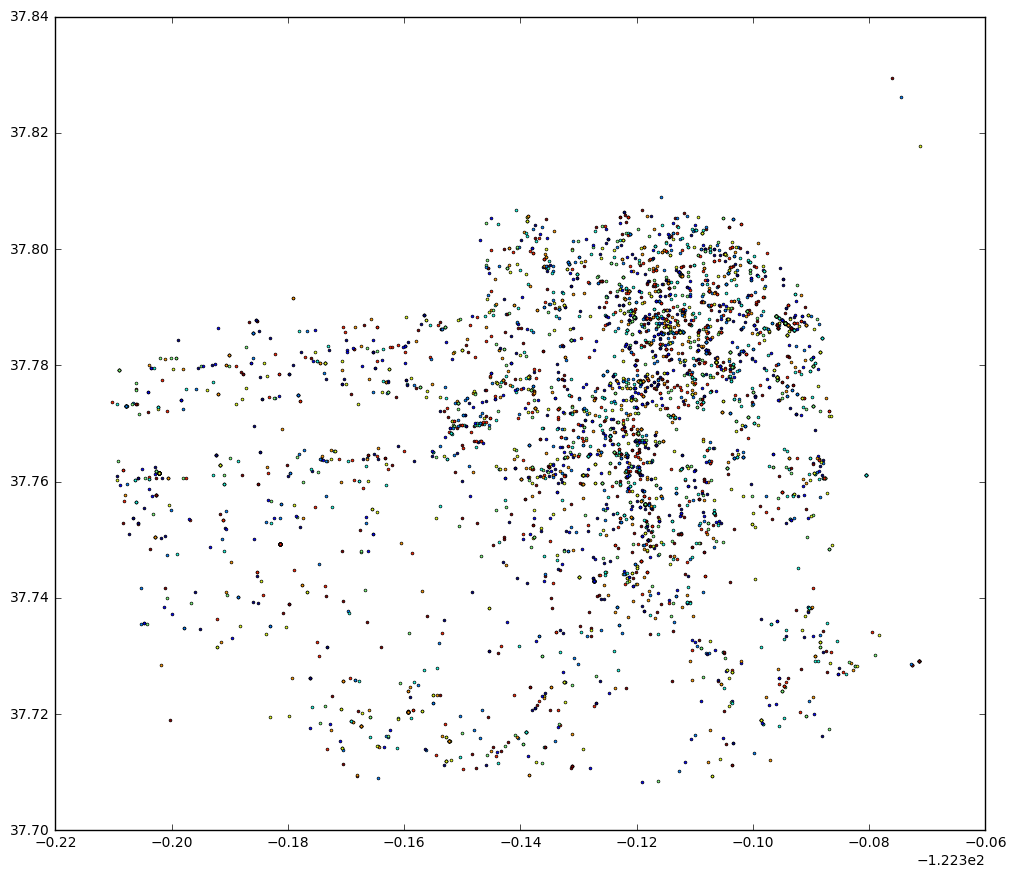

In [35]:
noise.plot()

In [36]:
zips1 = gpd.read_file("cb_2015_us_zcta510_500k.shp")

In [37]:
zips1.head()

,AFFGEOID10,ALAND10,AWATER10,GEOID10,ZCTA5CE10,geometry
0,8600000US36907,322847900,352811,36907,36907,"POLYGON ((-88.41800160107559 32.3381764852796,..."
1,8600000US85922,1011640213,789332,85922,85922,"POLYGON ((-109.282102 33.708941, -109.281566 3..."
2,8600000US84536,1546879191,209429,84536,84536,"POLYGON ((-110.709068 37.258372, -110.708278 3..."
3,8600000US94929,2749903,0,94929,94929,"(POLYGON ((-122.968755 38.237523, -122.965434 ..."
4,8600000US96086,664958004,1492676,96086,96086,"POLYGON ((-123.40933 41.987242, -123.407847 41..."


In [38]:
zips1 = zips1[zips1.ZCTA5CE10.str.startswith("9")] ##SF zip code start with 9
zips1 = zips1[pd.to_numeric(zips1.ZCTA5CE10) <= 94188] ##max range for zip
zips1 = zips1[pd.to_numeric(zips1.ZCTA5CE10) >= 94102] ## min range for zip

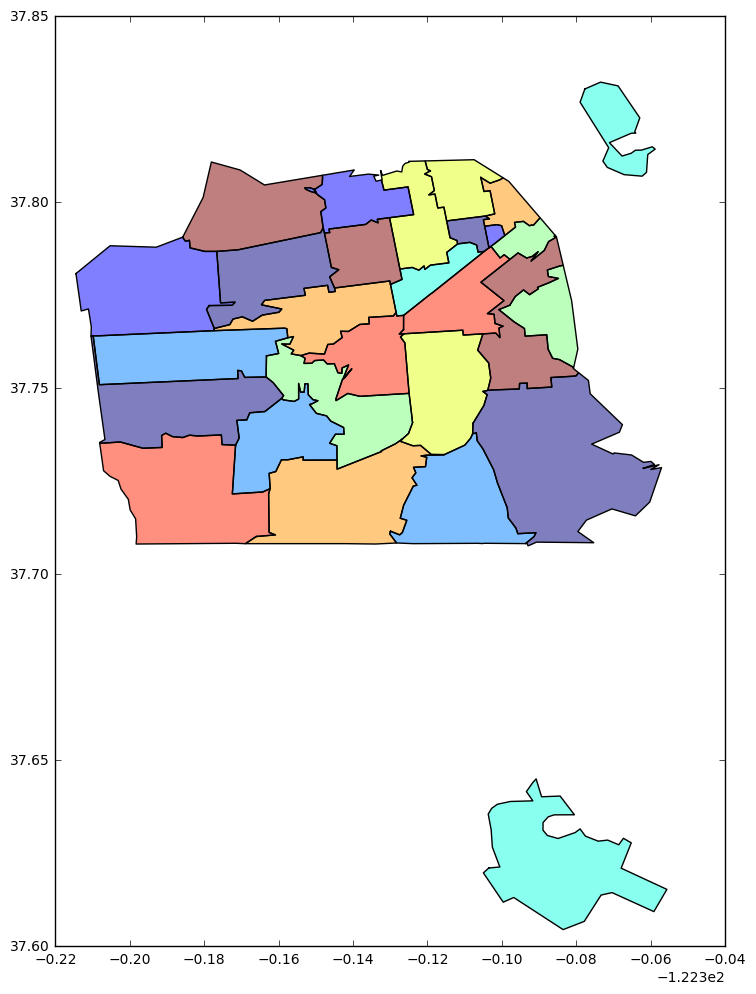

In [40]:
zips1.plot()

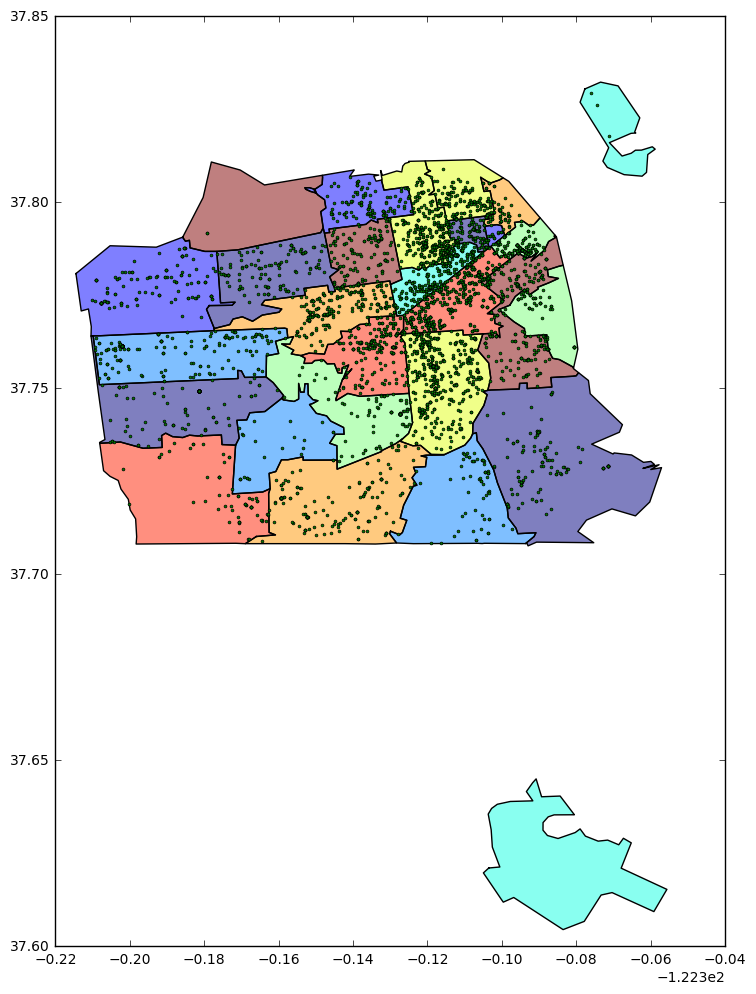

In [41]:
base = zips1.plot()
noise.plot(ax = base, marker = "o", color = "green")

In [42]:
noise = pd.read_sql("SELECT *, COUNT(*) FROM noise GROUP BY Type, Neighborhood", db)
noise = noise[pd.notnull(noise['Type'])]
noise.sort_values("COUNT(*)", ascending = False)

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon,COUNT(*)
555,6678376,other_excessive_noise,"1282 30TH AVE, SAN FRANCISCO, CA, 94122",None,2016-12-31 12:52:10,37.763455,-122.488609,162
619,6413296,other_excessive_noise,Intersection of NORIEGA ST and 21ST AVE,Outer Sunset,2016-10-12 15:43:18,37.754146,-122.478616,149
163,6689094,construction_private_property,"215 FREMONT ST, SAN FRANCISCO, CA, 94105",South of Market,2017-01-04 09:19:11,37.788943,-122.394563,100
90,6668200,construction_private_property,"101 LUNDYS LN, SAN FRANCISCO, CA, 94110",None,2016-12-28 10:12:12,37.743646,-122.418823,84
608,6693988,other_excessive_noise,"2196 MISSION ST, SAN FRANCISCO, CA, 94110",Mission,2017-01-05 10:35:57,37.761998,-122.419535,77
790,6633249,traffic,Intersection of 1ST ST and FOLSOM ST,South of Market,2016-12-15 21:56:51,37.787298,-122.394481,66
336,6686811,entertainment,"2943 MISSION ST, SAN FRANCISCO, CA, 94110",Mission,2017-01-03 14:42:01,37.749954,-122.418041,65
238,6674327,construction_public,Intersection of 9TH ST and MARKET ST,South of Market,2016-12-29 22:50:33,37.777494,-122.416292,60
786,6592357,traffic,Intersection of 1ST ST and GUY PL,Rincon Hill,2016-12-03 18:59:07,37.786852,-122.393921,59
43,6650396,amplified_sound_electronics,"2196 MISSION ST, SAN FRANCISCO, CA, 94110",Mission,2016-12-21 13:52:58,37.761998,-122.419535,55


1.2.3

My next question is interest is areas with the most parks. This information is useful for people looking to purchase near many parks or for someone who is interested in visiting many parks or playgrounds around a concentrated area. Like with the noise example, I subsetted the long and lat to get rid of the outlier. For this example however I used the parks table. I first plotted the areas of the parks, then plotted the sf area map as well limiting the area to the max and min zip code ranges found in wikipedia. Someone interested in many nearby parks should go to the 94110 and 94131 areas. However, a limation on this is that we do not know how large the parks are. It is interesting to note that in areas where there are many parks there are also many noise complaints. Therefore a house buyer will need to weigh the benefit of having a park nearby with the cost of many noise complaints. 

In [165]:

parks = pd.read_sql("SELECT * FROM parks", db)
pd.read_sql("SELECT * FROM parks", db)

,Name,Type,Acreage,ParkID,Lat,Lon
0,10TH AVE/CLEMENT MINI PARK,Mini Park,0.66,156,37.781844,-122.468099
1,15TH AVENUE STEPS,Mini Park,0.26,185,37.759565,-122.472268
2,24TH/YORK MINI PARK,Mini Park,0.12,51,37.753060,-122.408575
3,29TH/DIAMOND OPEN SPACE,Neighborhood Park or Playground,0.82,194,37.743602,-122.435236
4,ADAM ROGERS PARK,Neighborhood Park or Playground,2.74,46,37.731016,-122.383855
5,ALAMO SQUARE,Neighborhood Park or Playground,12.70,117,37.776349,-122.434674
6,ALICE CHALMERS PLAYGROUND,Neighborhood Park or Playground,1.68,25,37.709827,-122.446651
7,ALICE MARBLE TENNIS COURTS,Neighborhood Park or Playground,0.84,151,37.801428,-122.420343
8,ALIOTO MINI PARK,Mini Park,0.16,62,37.758902,-122.418217
9,ALLYNE PARK,Neighborhood Park or Playground,0.75,131,37.797461,-122.427600


In [40]:
parks = pd.read_sql("SELECT * FROM parks", db)
parks

,Name,Type,Acreage,ParkID,Lat,Lon
0,10TH AVE/CLEMENT MINI PARK,Mini Park,0.66,156,37.781844,-122.468099
1,15TH AVENUE STEPS,Mini Park,0.26,185,37.759565,-122.472268
2,24TH/YORK MINI PARK,Mini Park,0.12,51,37.753060,-122.408575
3,29TH/DIAMOND OPEN SPACE,Neighborhood Park or Playground,0.82,194,37.743602,-122.435236
4,ADAM ROGERS PARK,Neighborhood Park or Playground,2.74,46,37.731016,-122.383855
5,ALAMO SQUARE,Neighborhood Park or Playground,12.70,117,37.776349,-122.434674
6,ALICE CHALMERS PLAYGROUND,Neighborhood Park or Playground,1.68,25,37.709827,-122.446651
7,ALICE MARBLE TENNIS COURTS,Neighborhood Park or Playground,0.84,151,37.801428,-122.420343
8,ALIOTO MINI PARK,Mini Park,0.16,62,37.758902,-122.418217
9,ALLYNE PARK,Neighborhood Park or Playground,0.75,131,37.797461,-122.427600


In [41]:
lonlat = [geom.Point(Lon, Lat) for Lon, Lat in zip(parks.Lon, parks.Lat)]
parks.drop(["Lon", "Lat"], axis = 1)

parks = gpd.GeoDataFrame(parks, geometry = lonlat, crs = {'init' :'epsg:4326'})
parks.geometry.head()

0    POINT (-122.46809908 37.78184397)
1    POINT (-122.47226783 37.75956493)
2    POINT (-122.40857543 37.75306042)
3    POINT (-122.43523589 37.74360211)
4    POINT (-122.38385466 37.73101645)
Name: geometry, dtype: object

In [48]:
parks = parks.loc[parks['Lon'] < -122.0]
parks


,Name,Type,Acreage,ParkID,Lat,Lon,geometry
0,10TH AVE/CLEMENT MINI PARK,Mini Park,0.66,156,37.781844,-122.468099,POINT (-122.46809908 37.78184397)
1,15TH AVENUE STEPS,Mini Park,0.26,185,37.759565,-122.472268,POINT (-122.47226783 37.75956493)
2,24TH/YORK MINI PARK,Mini Park,0.12,51,37.753060,-122.408575,POINT (-122.40857543 37.75306042)
3,29TH/DIAMOND OPEN SPACE,Neighborhood Park or Playground,0.82,194,37.743602,-122.435236,POINT (-122.43523589 37.74360211)
4,ADAM ROGERS PARK,Neighborhood Park or Playground,2.74,46,37.731016,-122.383855,POINT (-122.38385466 37.73101645)
5,ALAMO SQUARE,Neighborhood Park or Playground,12.70,117,37.776349,-122.434674,POINT (-122.43467396 37.77634875)
6,ALICE CHALMERS PLAYGROUND,Neighborhood Park or Playground,1.68,25,37.709827,-122.446651,POINT (-122.44665065 37.7098271)
7,ALICE MARBLE TENNIS COURTS,Neighborhood Park or Playground,0.84,151,37.801428,-122.420343,POINT (-122.42034327 37.80142776)
8,ALIOTO MINI PARK,Mini Park,0.16,62,37.758902,-122.418217,POINT (-122.41821702 37.75890196)
9,ALLYNE PARK,Neighborhood Park or Playground,0.75,131,37.797461,-122.427600,POINT (-122.42759992 37.79746066)


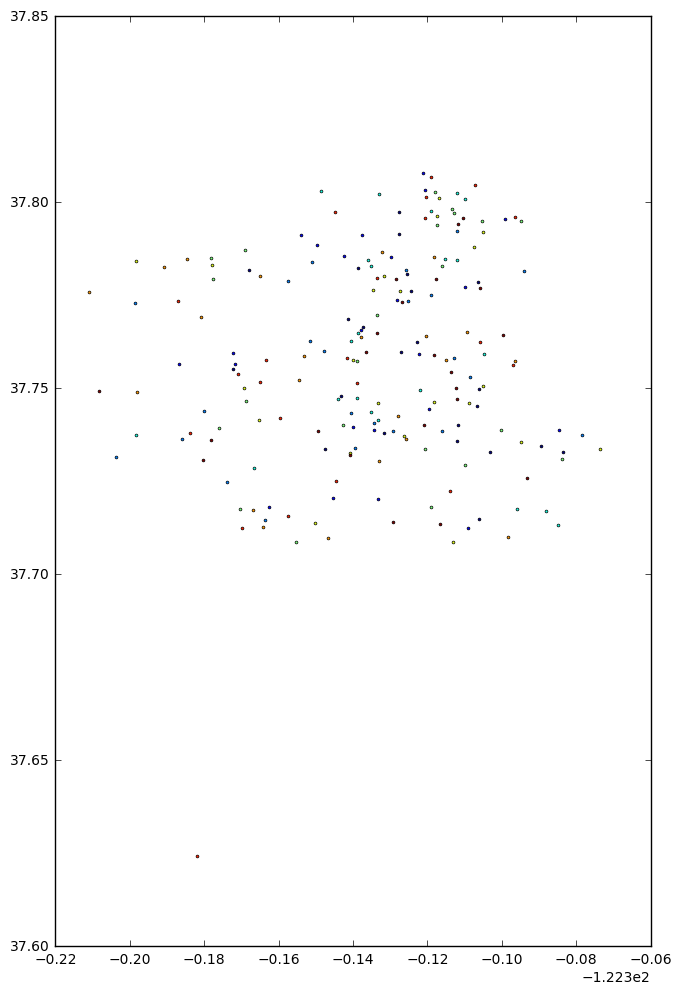

In [70]:
lonlat = [geom.Point(Lon, Lat) for Lon, Lat in zip(parks.Lon, parks.Lat)]
parks.drop(["Lon", "Lat"], axis = 1)

parks = gpd.GeoDataFrame(parks, geometry = lonlat, crs = {'init' :'epsg:4326'})
parks.geometry.head()
parks.plot()

In [44]:
zips = gpd.read_file("cb_2015_us_zcta510_500k.shp")


In [50]:
zips.head()

,AFFGEOID10,ALAND10,AWATER10,GEOID10,ZCTA5CE10,geometry
0,8600000US36907,322847900,352811,36907,36907,"POLYGON ((-88.41800160107559 32.3381764852796,..."
1,8600000US85922,1011640213,789332,85922,85922,"POLYGON ((-109.282102 33.708941, -109.281566 3..."
2,8600000US84536,1546879191,209429,84536,84536,"POLYGON ((-110.709068 37.258372, -110.708278 3..."
3,8600000US94929,2749903,0,94929,94929,"(POLYGON ((-122.968755 38.237523, -122.965434 ..."
4,8600000US96086,664958004,1492676,96086,96086,"POLYGON ((-123.40933 41.987242, -123.407847 41..."


In [51]:

zips = zips[zips.ZCTA5CE10.str.startswith("9")]
zips = zips[pd.to_numeric(zips.ZCTA5CE10) <= 94188] ##max range for zip
zips = zips[pd.to_numeric(zips.ZCTA5CE10) >= 94102] ## min range for zip


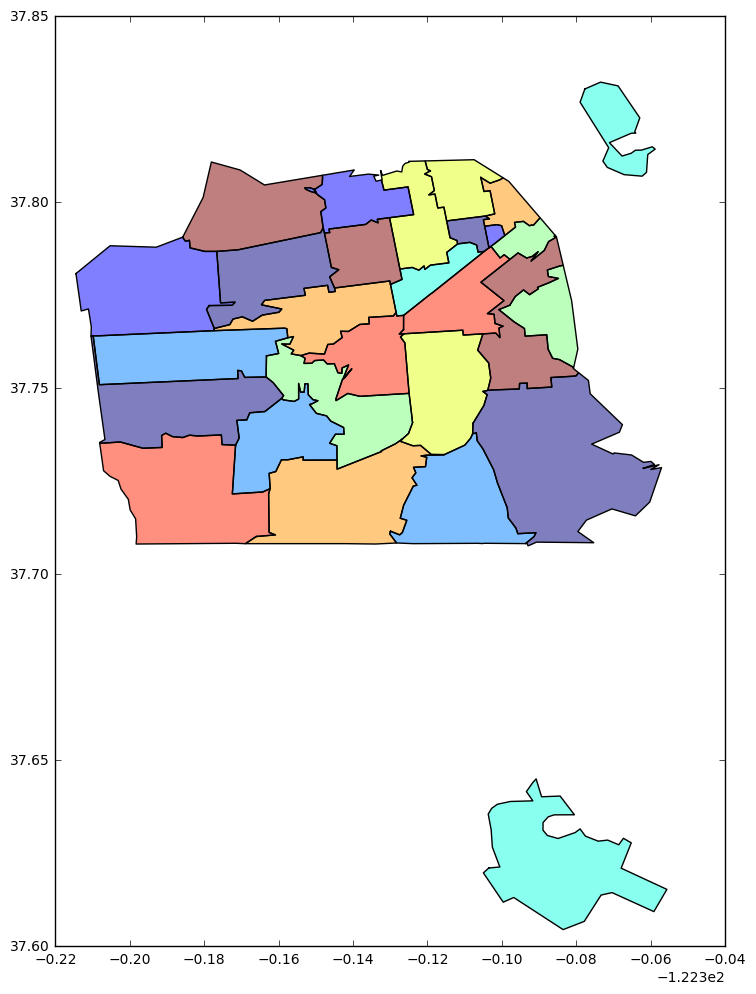

In [52]:
zips.plot()

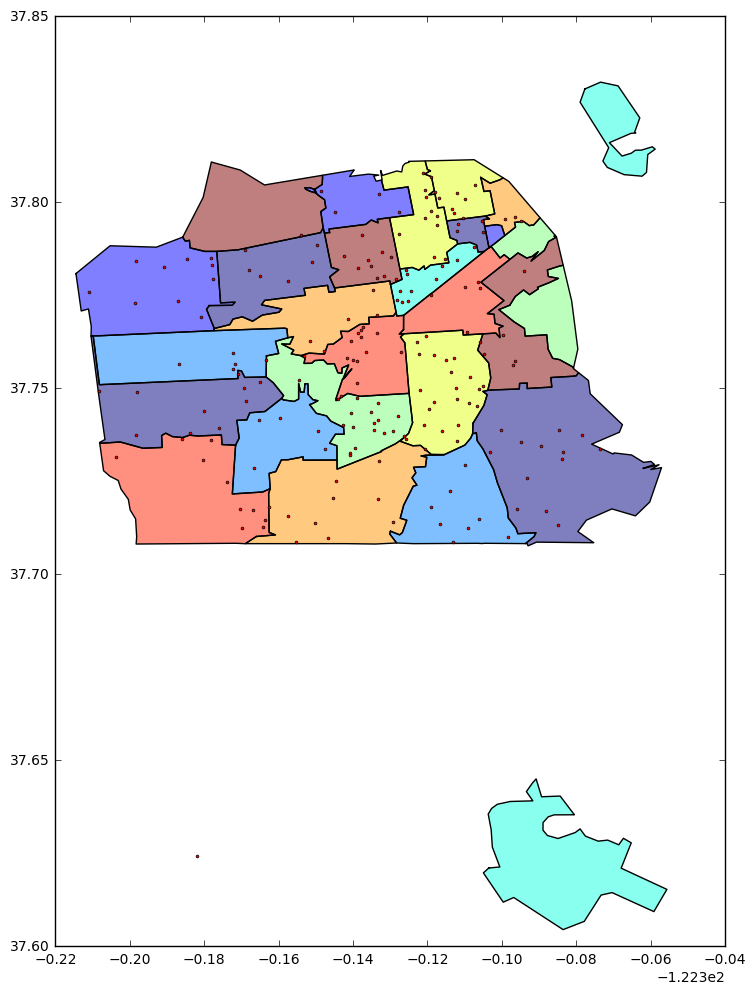

In [217]:
base = zips.plot()
parks.plot (ax = base, marker = "o", color = "red")

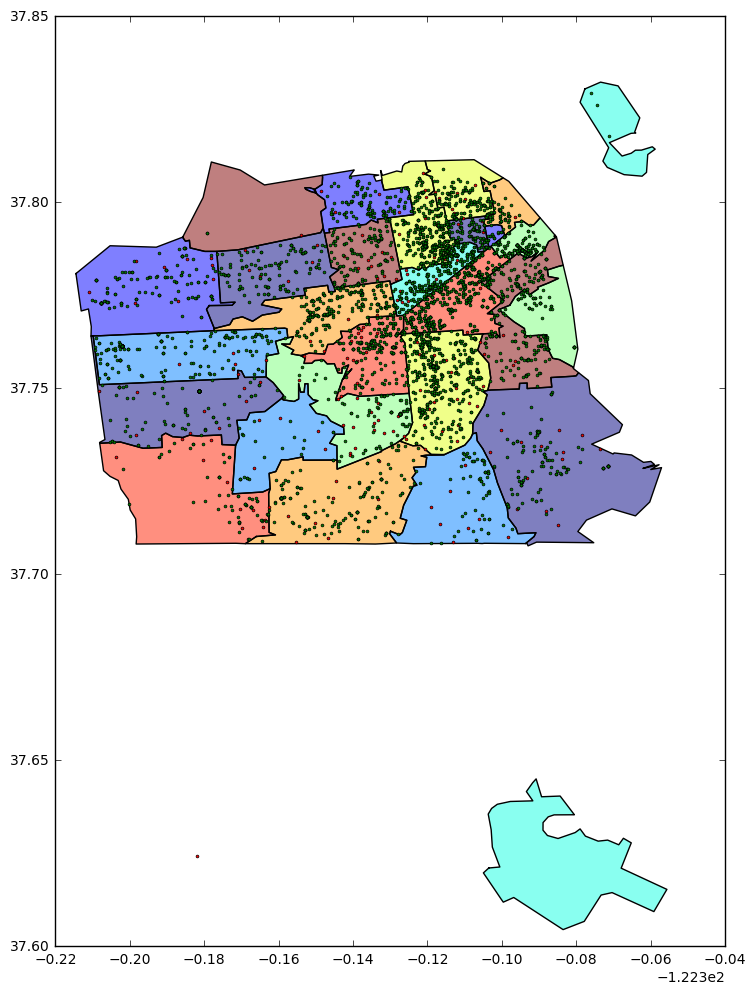

In [66]:
base = zips.plot()
parks.plot (ax = base, marker = "o", color = "red")
noise.plot (ax = base, marker = "o", color = "green")

1.2.4

For this fourth question I decided to look into the median sold price per sqft of all homes using the zillow table. I decided to see if there was any relationship between the median sold price and the following variables: ZRI per sq ft (median of the estimated montly rent price of all homes, per square foot), price to rent ratio of all homes, and turnover of all homes. Using an OLS regression finds that all three variables are very significant with regards to median sold price at the .01 level. Price to Rent appears to be postively correlated, as well as ZriPerSqft, this indicates that when these two variables increase, that the expected median sold price per sqft of all homes will incease as well. Turnover appears to be negatively correlated, as the turnover value increased, the expected value of median sold price will decrease. It is interesting to note as well that the Adjusted R squared value is .946, this indicates that 94.6% of the variation in the median sold price per sqft of all homes can be explained by the three variables we tested. 

In [72]:
zillow = pd.read_sql("SELECT * FROM zillow", db)
zillow

,RegionName,Date,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
0,94109,2010-11-01 00:00:00,3.156,675.1913,19.14,6.0771
1,94110,2010-11-01 00:00:00,2.566,599.6785,18.10,5.4490
2,94122,2010-11-01 00:00:00,2.168,495.4432,17.99,2.4198
3,94080,2010-11-01 00:00:00,1.666,369.5538,18.31,3.8757
4,94112,2010-11-01 00:00:00,2.322,422.4538,14.44,3.1288
5,94115,2010-11-01 00:00:00,3.000,667.1225,20.17,4.9020
6,94117,2010-11-01 00:00:00,2.556,751.9414,20.04,4.4494
7,94121,2010-11-01 00:00:00,2.170,500.4239,18.84,3.0160
8,94102,2010-11-01 00:00:00,3.212,NaN,15.35,6.6625
9,94118,2010-11-01 00:00:00,2.448,578.9903,NaN,3.9754


In [73]:
zillow = zillow[pd.notnull(zillow['MedianSoldPricePerSqft_AllHomes'])]
zillow.sort_values("MedianSoldPricePerSqft_AllHomes", ascending = False) ## sort gives depreciation warning, need sort_values

,RegionName,Date,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
5488,94104,2007-10-01 00:00:00,NaN,1336.128581,NaN,22.9730
1638,94123,2016-04-01 00:00:00,4.718,1286.297641,26.14,4.0655
1663,94123,2016-05-01 00:00:00,4.704,1276.685200,25.26,4.2349
1297,94105,2015-02-01 00:00:00,4.852,1276.585300,20.19,7.0017
1322,94105,2015-03-01 00:00:00,4.920,1270.436000,20.34,6.9529
1622,94105,2016-03-01 00:00:00,5.150,1269.393512,20.93,5.0988
1397,94105,2015-06-01 00:00:00,5.080,1262.993800,20.67,5.9527
1372,94105,2015-05-01 00:00:00,5.036,1261.621700,20.55,6.2210
1513,94123,2015-11-01 00:00:00,4.788,1255.707763,25.15,4.4043
1347,94105,2015-04-01 00:00:00,4.990,1242.558400,20.56,6.4406


In [74]:
result = sm.ols(formula = "MedianSoldPricePerSqft_AllHomes ~ PriceToRentRatio_AllHomes +Turnover_AllHomes +ZriPerSqft_AllHomes", data = zillow).fit()
print result.params
print result.summary()

Intercept                   -572.544820
PriceToRentRatio_AllHomes     29.266381
Turnover_AllHomes            -11.373028
ZriPerSqft_AllHomes          247.194154
dtype: float64
                                   OLS Regression Results                                  
Dep. Variable:     MedianSoldPricePerSqft_AllHomes   R-squared:                       0.946
Model:                                         OLS   Adj. R-squared:                  0.946
Method:                              Least Squares   F-statistic:                     5728.
Date:                             Sun, 19 Mar 2017   Prob (F-statistic):               0.00
Time:                                     21:35:29   Log-Likelihood:                -5322.5
No. Observations:                              990   AIC:                         1.065e+04
Df Residuals:                                  986   BIC:                         1.067e+04
Df Model:                                        3                                       

1.2.5 

For my last question I wanted to look into the most expensive and least expensive median sold price per sq ft of all homes. However, because the value is taken every month, I decided to take the median of the prices by zipcode instead of the mean to account for outliers. The most expensive area appears to be 94104 which is the heart of the financial district so this is not surprising. The least expensive area is 94124, which is quite far away from the national park and financial district. Additionally this area appears to have many less parks and noise complaints compared to other areas. While I expected the price to be higher due to the lower amount of noise complaints, it is possible that the benefit of lower noise complaints is offset by the cost of the location with regards to proximity to the national park, financial district, and major bridge. While there are some NAN values in the other columns, the person purchasing the home is only interested in the median sold price, not the other column values. I am assuming that the NAN values being present do not make the median sold price inaccurate. 

In [76]:
zillow = zillow[pd.notnull(zillow['MedianSoldPricePerSqft_AllHomes'])]
zillow = zillow.sort_values("MedianSoldPricePerSqft_AllHomes", ascending = False) ## sort gives depreciation warning, need sort_values
zillow

,RegionName,Date,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
5488,94104,2007-10-01 00:00:00,NaN,1336.128581,NaN,22.9730
1638,94123,2016-04-01 00:00:00,4.718,1286.297641,26.14,4.0655
1663,94123,2016-05-01 00:00:00,4.704,1276.685200,25.26,4.2349
1297,94105,2015-02-01 00:00:00,4.852,1276.585300,20.19,7.0017
1322,94105,2015-03-01 00:00:00,4.920,1270.436000,20.34,6.9529
1622,94105,2016-03-01 00:00:00,5.150,1269.393512,20.93,5.0988
1397,94105,2015-06-01 00:00:00,5.080,1262.993800,20.67,5.9527
1372,94105,2015-05-01 00:00:00,5.036,1261.621700,20.55,6.2210
1513,94123,2015-11-01 00:00:00,4.788,1255.707763,25.15,4.4043
1347,94105,2015-04-01 00:00:00,4.990,1242.558400,20.56,6.4406


In [84]:
zillow = zillow.groupby('RegionName').median().reset_index()
zillow = zillow.sort_values("MedianSoldPricePerSqft_AllHomes", ascending = False) ## sort gives depreciation warning, need sort_values
zillow ##most expensive median sold price is 94104 and least expensive is 94124

,RegionName,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
3,94104,NaN,1336.128581,NaN,22.973000
4,94105,4.251231,798.257824,20.340000,7.762266
18,94123,3.576556,696.166788,26.391944,6.198377
25,94158,4.332000,657.211820,20.340000,15.568848
11,94114,3.289906,650.127729,23.987692,5.707688
23,94133,3.598333,638.636839,21.103333,6.676639
1,94102,4.124545,626.417276,16.716364,7.940784
7,94109,3.775290,618.325709,19.200476,6.716760
12,94115,3.510436,611.771452,21.510893,6.210149
2,94103,3.694955,604.009929,17.796136,7.963514


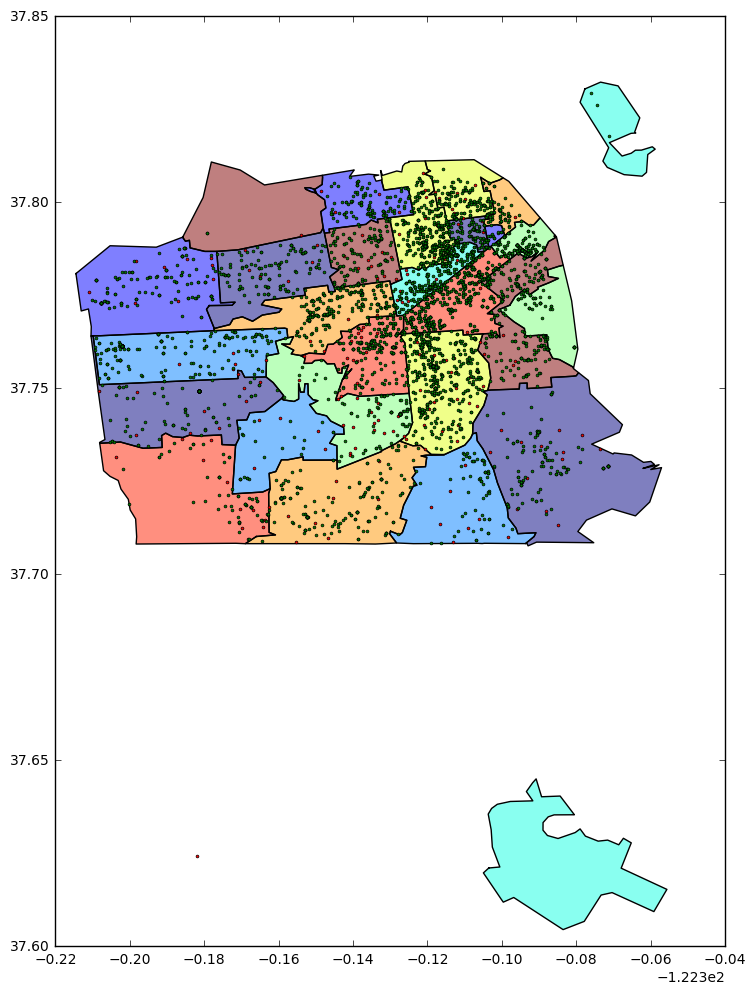

In [83]:
base = zips.plot()
parks.plot (ax = base, marker = "o", color = "red")
noise.plot (ax = base, marker = "o", color = "green")

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.